env: sklearn

# <font color = 'purple'>Filling Missing Cholesterol Data (Linear Regression)   
The raw heart disease dataset has entries with mising cholesterol data. As this affects a significant number of entries, we need to find a way to fill these missing values, or drop the cholesterol feature from our analysis.   

In this notebook we explore whether we can use linear regression on the remaining features to predict the missing cholesterol values.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

from scipy import stats

In [2]:
#set default style for plots
sns.set_style("whitegrid")
matplotlib.rcParams.update({'font.size': 8})

#set working directory
os.chdir(r"C:\Users\sharo\Documents\Postgrad\My Data Science Portfolio\Classification - Heart Disease")

## <font color = 'blue'>Import Raw Data

In [3]:
df = pd.read_csv("heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [5]:
df.FastingBS.value_counts() 

0    704
1    214
Name: FastingBS, dtype: int64

In [6]:
len(df[df.Cholesterol<=0])/len(df) #around 19% of data has missing Cholesterol values

0.18736383442265794

In [7]:
# for our regression model we will use the entries with cholesterol values to facilitate supervised learning
# from our Data Exploration & Cleaning notebook, we also know there is 1 entry with mission RestingBP. Exclude this entry.
df_1 = df[(df.Cholesterol>0) & (df.RestingBP>0)]
len(df_1) #746 training data points

746

In [8]:
# we will not use the 'HeartDisease' column as a covariate for regression as we would not have this for test data
# for the remaining columns, convert categorical variables into indicator variables
df_2 = df_1.drop(columns='HeartDisease')
df_2 = pd.get_dummies(df_2, drop_first=True)
df_2.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.0,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.5,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.0,1,0,1,0,1,0,0,0,1


## <font color = 'blue'> Scale Numeric Features

In [9]:
df_X = df_2.drop(columns='Cholesterol')
df_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 746 entries, 0 to 917
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                746 non-null    int64  
 1   RestingBP          746 non-null    int64  
 2   FastingBS          746 non-null    int64  
 3   MaxHR              746 non-null    int64  
 4   Oldpeak            746 non-null    float64
 5   Sex_M              746 non-null    uint8  
 6   ChestPainType_ATA  746 non-null    uint8  
 7   ChestPainType_NAP  746 non-null    uint8  
 8   ChestPainType_TA   746 non-null    uint8  
 9   RestingECG_Normal  746 non-null    uint8  
 10  RestingECG_ST      746 non-null    uint8  
 11  ExerciseAngina_Y   746 non-null    uint8  
 12  ST_Slope_Flat      746 non-null    uint8  
 13  ST_Slope_Up        746 non-null    uint8  
dtypes: float64(1), int64(4), uint8(9)
memory usage: 41.5 KB


In [10]:
X_num = df_X.select_dtypes(exclude='uint8').to_numpy() #extract numeric features
scaler = StandardScaler() #instantiate scaler (tried both MinMaxScaler and StandardScaler; no difference in results)
X_num = scaler.fit_transform(X_num) #scale

X_cat = df_X.select_dtypes(include='uint8').to_numpy() #extract dummy variables

X = np.hstack((X_num, X_cat)) #combine scaled numeric, and unscaled dummy variables
X.shape

(746, 14)

In [11]:
y = df_2['Cholesterol'].to_numpy()
y.shape

(746,)

## <font color = 'blue'> Train Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #random state fixed to compare impact of different scalers

## <font color = 'blue'>Train

In [13]:
lm_1=LinearRegression() #instantiate
lm_1.fit(X_train,y_train) #fit

LinearRegression()

In [14]:
# check training accuracy
pred_train = lm_1.predict(X_train)
rmse_train = mean_squared_error(y_true = y_train, y_pred = pred_train, squared=False)
print(f"Root Mean Squared Error on Training Set: {rmse_train}")
print(f"Range of y_train: {min(y_train)} - {max(y_train)}")

Root Mean Squared Error on Training Set: 56.5997810836798
Range of y_train: 85 - 603


In view of the range of cholesterol values, the RMSE is quite large.

Text(0, 0.5, 'prediction')

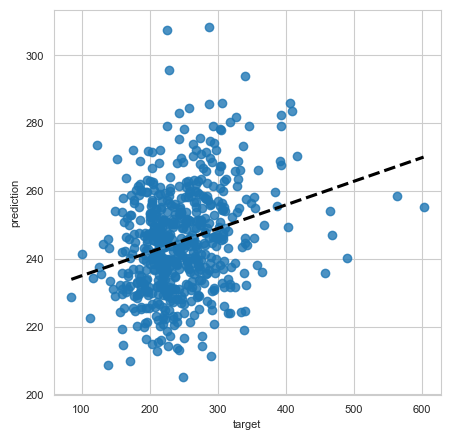

In [15]:
fig, ax = plt.subplots(figsize=(5,5))
sns.regplot(x=y_train, y=pred_train, ci=False, line_kws={'color':'black', 'linestyle':'dashed'})
ax.set_xlabel('target')
ax.set_ylabel('prediction')

In [16]:
R2 = r2_score(y_train, pred_train)
R2

0.06961852466215213

R2 value is very close to zero, indicating that the linear model is only marginally better than using the mean as our estimate. This poor fit is corroborated by the scatter plot.

## <font color = 'blue'> Test

In [17]:
# check test accuracy
pred_test = lm_1.predict(X_test)
rmse_train = mean_squared_error(y_true = y_test, y_pred = pred_test, squared=False)
print(f"Root Mean Squared Error on Test Set: {rmse_train}")
print(f"Range of y_test: {min(y_test)} - {max(y_test)}")

Root Mean Squared Error on Test Set: 61.83100159015669
Range of y_test: 100 - 529


Text(0, 0.5, 'prediction')

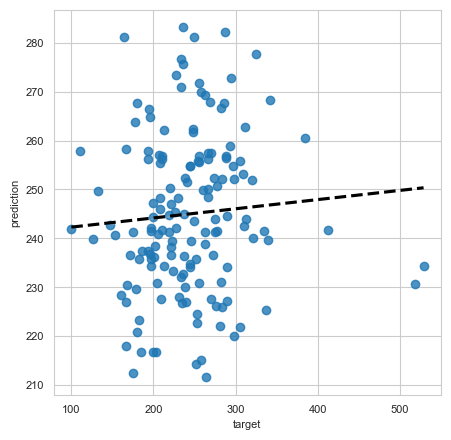

In [18]:
fig, ax = plt.subplots(figsize=(5,5))
sns.regplot(x=y_test, y=pred_test, ci=False, line_kws={'color':'black', 'linestyle':'dashed'})
ax.set_xlabel('target')
ax.set_ylabel('prediction')

In [19]:
R2 = r2_score(y_test, pred_test)
R2

-0.03480677703157342

As expected, the performance on the test set is even poorer than the training set. In fact, the negative R2 value indicates that using the mean as our prediction would be more accurate. We could go into feature selection by performing hypothesis tests on the coefficients, but given how poor the performance is at this stage, a linear model may not be the best approach. 